# Bayesian option pricing
We look into particle filter aided Bayesian option pricing

## The Geometric Brownian motion
Assume that the risky asset can be modelled by the GBM
$$ dX_t = \mu(X_t)dt + \sigma(X_t)dW_t, $$
where $X_t$ is the price, $\mu$ the drift function, $\sigma$ the volatility function, and $dW_t$ a Weiner process.

We consider $\mu(X_t) := \mu X_t$ and $\sigma(X_t) := \sigma X_t$

## Numerical stepping
the GBM can be modeled directly to from t to T, but as an introduciton we use the Euler discretization,
$$ X_{j+1} = X_j + \mu X_j \Delta t + \sigma X_j \sqrt{\Delta t} Z_j, $$
where $Z_j \sim \mathcal{N}(0,1)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def GBM_euler(X0, mu, sigma, T, N, M = 1):
    # initialize the price
    X = X0*np.ones([N,M])
    dt = T/(N+1)
    sqrtdt = np.sqrt(dt)
    
    # time-step
    for j in range(N):
        Z = np.random.randn(M)
        X[j,] = X[j-1,] + mu*X[j-1,]*dt + sigma*X[j-1,]*sqrtdt*Z
    return(X)

In [3]:
# constants
X0 = 14
mu = 0.1
sigma = 0.25
T = 0.5

N = 10
M = 10

In [4]:
X = GBM_euler(X0=X0, mu=mu, sigma=sigma, T=T, N=N, M=M)
t = np.linspace(0,T,N)

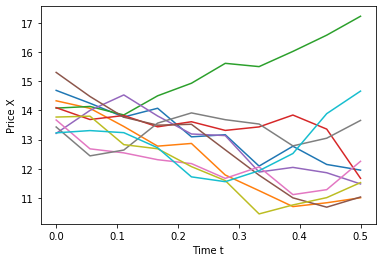

In [5]:
plt.plot(t,X)
plt.xlabel("Time t")
plt.ylabel("Price X")
plt.show()

## Analytical solution
As hinted above, there is a "true" solution for each step, naimly,
$$ X_t = X_0 \exp \bigg( (\mu - \frac{\sigma^2}{2})t - \sigma W_t \bigg). $$
This solution is derived through the use of Itô calculus.

In [6]:
def GBM(X0, mu, sigma, T, N, M = 1):
    dt = T/(N+1)
    step = np.exp((mu-sigma**2/2)*dt) * np.exp(sigma*np.random.normal(0,np.sqrt(dt),[N,M]))
    
    X = X0*step.cumprod(axis=0)

    return(X)

In [7]:
Y = GBM(X0, mu, sigma, T, N=1000, M=10)
Y[-1,]

array([12.12589636, 14.58040141, 15.75943644, 16.87115247, 18.87929217,
       11.74489384, 15.43056774, 13.52154536, 13.80530953, 15.12839121])

In [8]:
np.var(Y[-1,])

4.151051042625702

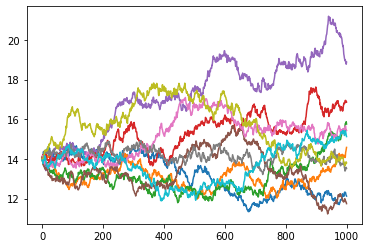

In [9]:
plt.plot(Y)
plt.show()

## Properties
From the analytical solution, we know some properties of the GBM. We know the expected value,
$$ \mathbb{E}(X_t) = X_0 e^{\mu t}, $$
and the variance,
$$ \mathbb{V}(X_t) = X_0^2 e^{2 \mu t} (e^{\sigma^2 t} - 1). $$

In [10]:
def gbm_exp(X0, mu, T):
    return(X0*np.exp(mu*T))

def gbm_var(X0, mu, sigma, T):
    return(X0**2 * np.exp(2*mu*T) * (np.exp(sigma**2 * T) - 1) )

In [11]:
gbm_exp(X0,mu,T)

14.717795349264337

In [12]:
gbm_var(X0,mu,sigma,T)

6.876050598492029

In [13]:
Y = GBM_euler(X0, mu, sigma, T, N, M=10000)
print("mean: ", np.mean(Y[-1,]))
print("var: ", np.var(Y[-1,]))

mean:  14.68776361548488
var:  6.111909722346364


# The particle filter
Given the observations $y$ we would like to estimate the probability $P(\mu, \sigma | y)$.

On the modeling, we can keep in mind that the log returns of $y$ are normally distributed,

$$ \log \frac{X_{j+1}}{X_j} =   (\mu - \frac{\sigma^2}{2})t - \sigma W_t, $$
with mean $(\mu - \frac{\sigma^2}{2})t$ and variance $\Delta t \sigma^2$.

In [14]:
Y

array([[14.42089534, 14.02842368, 13.40817012, ..., 14.18839101,
        13.45115098, 14.33132857],
       [15.68339901, 12.8846547 , 13.2554171 , ..., 14.19579176,
        14.3774808 , 14.02886681],
       [15.81718501, 14.24540625, 13.23096796, ..., 14.30352016,
        15.60867389, 14.60833844],
       ...,
       [17.25452601, 14.67777918, 13.16503797, ..., 16.60234549,
        15.12555165, 15.36423774],
       [16.96131789, 16.56423254, 12.93288542, ..., 17.06846617,
        14.80399988, 14.33645634],
       [15.61725484, 16.1572782 , 11.880417  , ..., 17.78477504,
        15.45456004, 14.36288058]])

(array([2., 1., 1., 0., 0., 1., 1., 0., 0., 2.]),
 array([0.06907137, 0.08513233, 0.1011933 , 0.11725427, 0.13331523,
        0.1493762 , 0.16543716, 0.18149813, 0.1975591 , 0.21362006,
        0.22968103]),
 <a list of 10 Patch objects>)

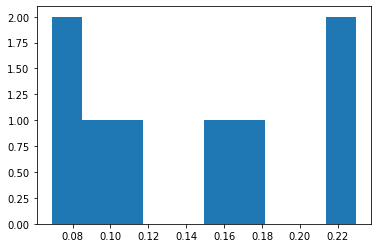

In [15]:
plt.hist(np.log(Y[2:N,1] / Y[1:N-1,2]))

In [16]:
from scipy.stats import norm

# list of ideas
1) Propose $\theta := [\mu, \sigma]$ from the prior on $\theta$
2) In the loop, we aim to converge to a tight distribution on $\theta$, by
    * The cloud step forward 1 step,
    * how weight? distance between X and y? How is it done for stochastic volatility?

## distribtution assumption
A GBM assumes the logarithmic change of the stock price to be a normally distirubted random variable according to:
$$ r_i = \log \bigg( \frac{S_{t_i}}{S_{t_{i-1}}} \bigg) 
= \mu + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0,\sigma^2) $$

In [82]:
def PF(y, mu, sigma, M, m0=1, s0=0.1):
    N = len(y)
    
    
    # inital guess from prior
    X = np.random.normal(mu, 1, [M,N])
    # inital weights
    w = np.ones(M)/M
    # start the procedure
    for i in range(N):
        ## resample
        a = np.random.choice(M, size=M, replace=True, p=w)
        
        ## propagate
        X[:,i] = np.random.normal(size=M, loc=X[a,i], scale=s0)
        
        ## weight
        w = norm.pdf(x=y[i], loc=X[:,i], scale=sigma)
        ## normalize
        w /= sum(w)
    
    return(X, w)
        

In [24]:
Y = GBM(X0, mu, sigma, T, N=1000, M=1)
y = Y[2:-1] / Y[1:-2]

In [83]:
X, w = PF(y, mu=mu*1.1, sigma=sigma, M=1000, m0=1, s0=0.1)

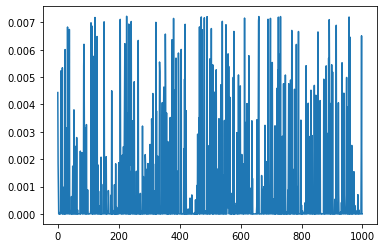

In [84]:
plt.plot(w)

In [85]:
np.dot(X[:,-1],w)

0.9329683903507471